# Result Analysis

*too: description*

In this notebook I analyse the results produced by running the experiment.

In [1]:
import logging
import os.path

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from metrics.mae import MAE
from metrics.coverage_rate import CoverageRate, RollingCoverageRate, CoveredDimensions, RollingCoverageRateByFeature
from metrics.infinity_count import InfinityCount
from metrics.interval_width import MeanIntervalWidth, RollingMeanIntervalWidth

logging.basicConfig(level=logging.INFO, format='%(levelname)s %(filename)s:%(lineno)s %(funcName)s() %(message)s')

%pwd

In [2]:
experiment_group_dir = '../../../assets/experimental_results/exp_06_tetouan_rnn'
weight_functions_and_corrections = {
    'sol_icp_bf_exp_b0.007': 'sol_icp_bf_exponential_b0.007.json',
    'sol_icp_bf_sc_c200_s50': 'sol_icp_bf_soft_cutoff_c200_s50.json',
    'sol_icp_bf_lin': 'sol_icp_bf_linear.json',
    'sol_icp_bf_cst': 'sol_icp_bf_constant.json',
    'ol_icp_bf_cst': 'ol_icp_bf_constant.json'
}
univariate_and_multivariate_ds = {
    'multv': 'elec2_ds_multivariate.json',
}

fig_names = ['Exponential', 'Soft Cutoff', 'Linear', 'Constant', 'Off-Line\nConstant']

experiment_dirs = []
for icp_setting, icp_params_file in weight_functions_and_corrections.items():
    for ds_setting, ds_params_file in univariate_and_multivariate_ds.items():
        experiment_dirs.append(f'{ds_setting}_{icp_setting}')

output dir

In [3]:
table_out_dir = Path(
    '/Users/filip.schlembach/Documents/uni/thesis_masters/latex/um_thesis_manuscript/tables/exp_06_tetouan_rnn')


def now() -> str:
    return datetime.datetime.now().strftime('%y%m%d_%H%M')

## MAE

In [4]:
mae_results = {exp_dir: MAE.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), MAE.snake_name())) for exp_dir in
    experiment_dirs}

print('underlying model mae on test set:', mae_results)

underlying model mae on test set: {'multv_sol_icp_bf_exp_b0.007': 0.03434734988066955, 'multv_sol_icp_bf_sc_c200_s50': 0.03069117011375666, 'multv_sol_icp_bf_lin': 0.031793465416559384, 'multv_sol_icp_bf_cst': 0.030725351383008685, 'multv_ol_icp_bf_cst': 0.040184306625539006}


Since they all perform more or less the same, I won't dive deeper into it.

## Coverage Rate

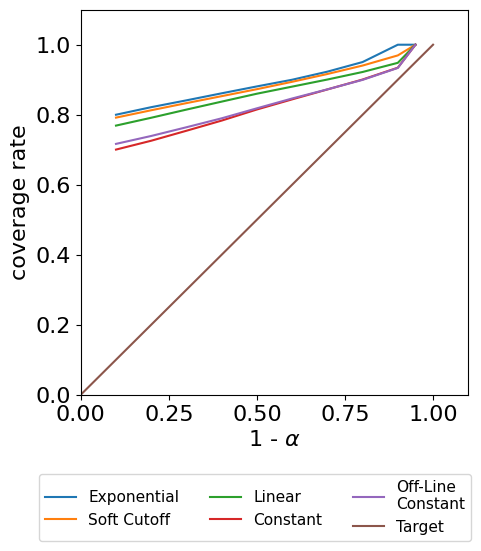

In [5]:
cr_results = [CoverageRate.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), CoverageRate.snake_name())) for exp_dir in
    experiment_dirs]
plt.rcParams.update({'font.size': 16})
CoverageRate.comparative_plot(cr_results, fig_names + ['Target'],
                              # save_path='comparison/' + CoverageRate.snake_name() + '.png'
                              fig_size=(5, 5))

In [6]:
cr_df = pd.DataFrame([[*cr_results[i][1]] for i in range(len(cr_results))], columns=1 - cr_results[0][0],
                     index=fig_names).T
cr_df = cr_df.round(decimals=3)
# cr_df.to_csv(table_out_dir / f'cr_{now()}.csv')
cr_df

,Exponential,Soft Cutoff,Linear,Constant,Off-Line\nConstant
0.10,0.800,0.792,0.769,0.700,0.717
0.20,0.822,0.813,0.791,0.726,0.739
0.30,0.841,0.833,0.815,0.754,0.764
0.40,0.861,0.853,0.837,0.783,0.790
0.50,0.881,0.873,0.860,0.815,0.818
0.60,0.900,0.894,0.880,0.844,0.846
0.70,0.923,0.916,0.901,0.872,0.872
0.80,0.950,0.940,0.922,0.901,0.900
0.90,1.000,0.969,0.948,0.934,0.934
0.95,1.000,1.000,1.000,1.000,1.000


### Rolling Coverage Rate

In [7]:
rcr_results = [RollingCoverageRate.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), RollingCoverageRate.snake_name())) for
    exp_dir in experiment_dirs]

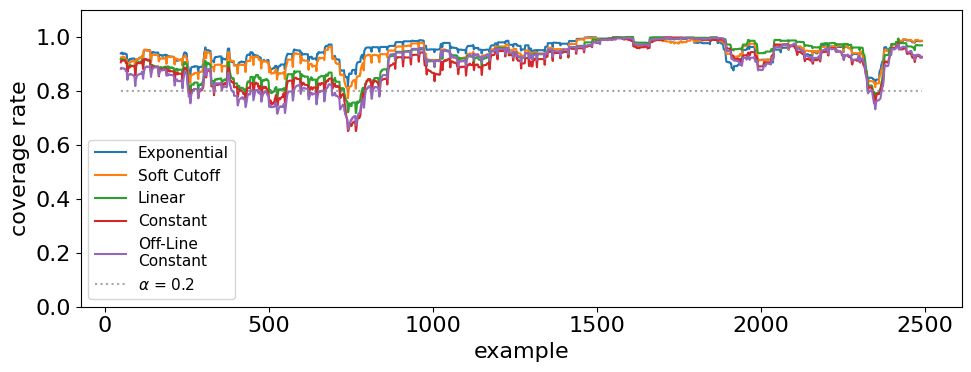

In [8]:
# for name, rcr_r in zip(fig_names, rcr_results):
#     RollingCoverageRate.simple_plot(rcr_r, name)
# RollingCoverageRate.comparative_plot(rcr_results, fig_names, 0.2, fig_size=(12, 6), title='Rolling Coverage Rate on the Tétouan City Data Set')
RollingCoverageRate.comparative_plot(rcr_results, fig_names, 0.2, fig_size=(10, 4))

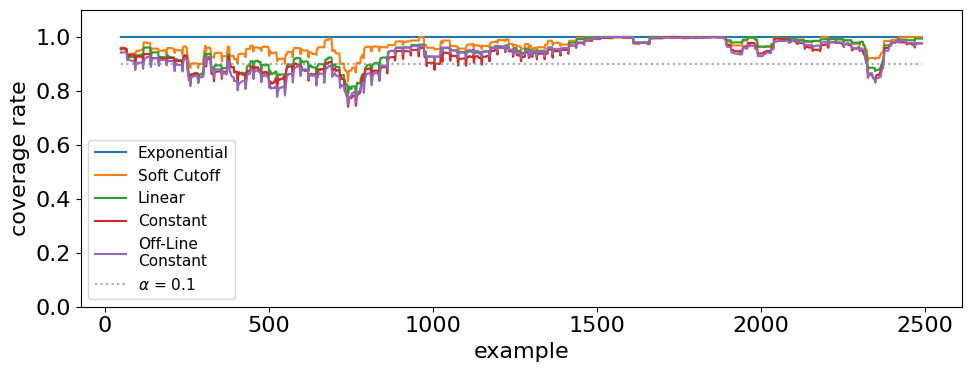

In [9]:
# RollingCoverageRate.comparative_plot(rcr_results, fig_names, 0.1, fig_size=(12, 6), title='Rolling Coverage Rate on the Tétouan City Data Set')
RollingCoverageRate.comparative_plot(rcr_results, fig_names, 0.1, fig_size=(10, 4))

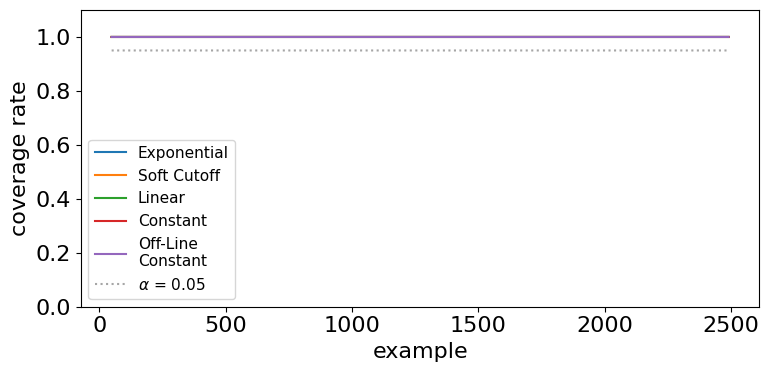

In [10]:
RollingCoverageRate.comparative_plot(rcr_results, fig_names, 0.05, fig_size=(8, 4))

### Rolling Coverage Rate by Feature

In [11]:
frcr_results = [RollingCoverageRateByFeature.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), RollingCoverageRateByFeature.snake_name())) for
    exp_dir in experiment_dirs]

In [12]:
rcr_by_feature = {f'feature_{i}': [] for i in range(3)}
for i in range(3):  # for every tested correction mehtod
    frcr_r_ex = frcr_results[i]
    for j in range(3):  # for every feature
        fcr_r_ex_f = (frcr_r_ex[0], frcr_r_ex[1][:, :, j], frcr_r_ex[2])
        rcr_by_feature[f'feature_{j}'].append(fcr_r_ex_f)

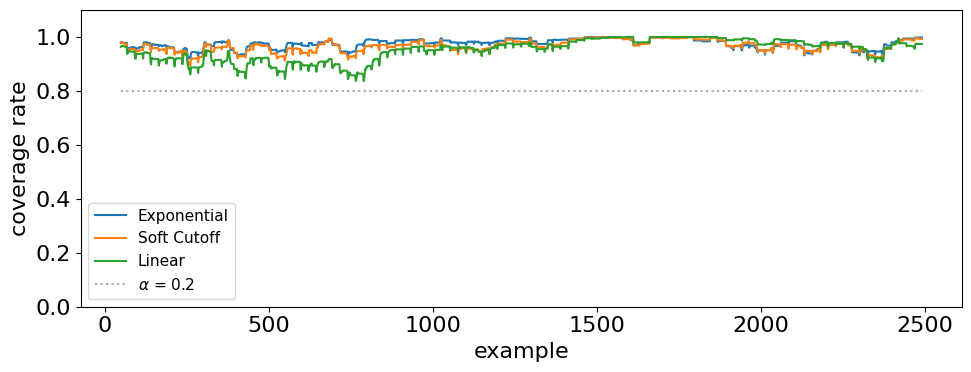

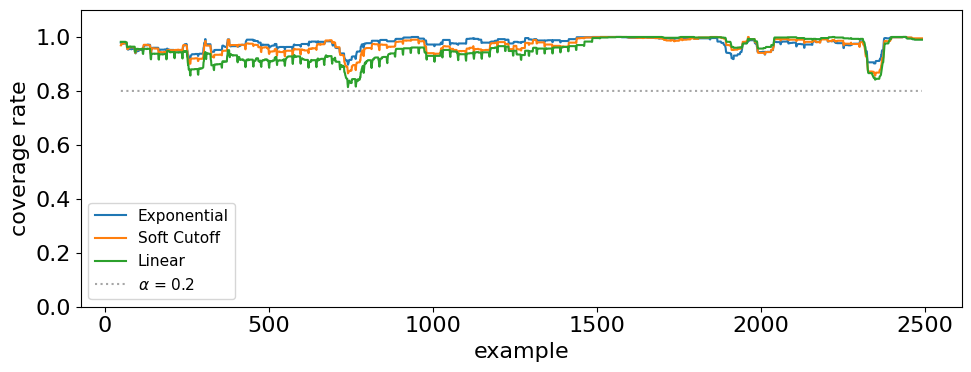

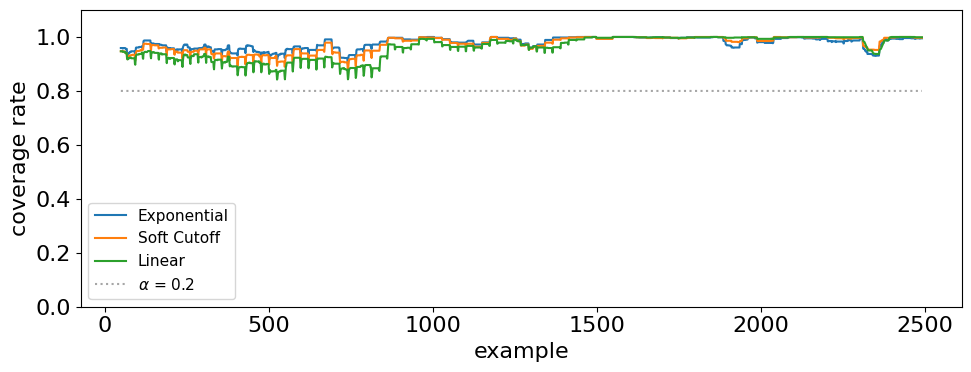

In [13]:
for i in range(3):
    RollingCoverageRate.comparative_plot(rcr_by_feature[f'feature_{i}'], fig_names, 0.2, fig_size=(10, 4))

## Interval width

In [14]:
miw_results = [MeanIntervalWidth.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), MeanIntervalWidth.snake_name())) for exp_dir
    in
    experiment_dirs]

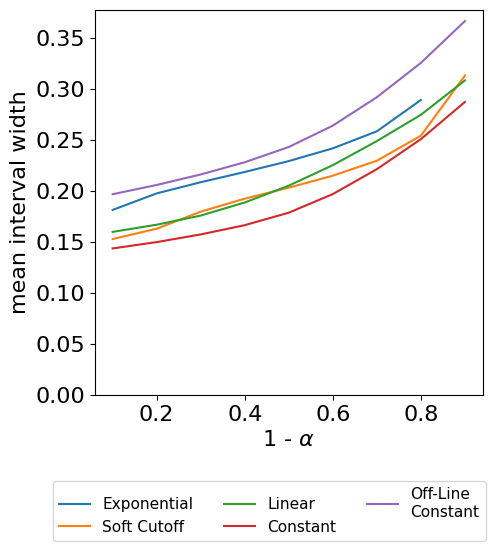

In [15]:
MeanIntervalWidth.comparative_plot(miw_results, fig_names,
                                   # save_path=os.path.join(experiment_group_dir,
                                   #                        f'comparison/{MeanIntervalWidth.snake_name()}.png')
                                   fig_size=(5, 5))

In [16]:
miw_df = pd.DataFrame([[*miw_results[i][1]] for i in range(len(miw_results))], columns=1 - miw_results[0][0],
                      index=fig_names).T
miw_df = miw_df.round(decimals=3)
# miw_df.to_csv(table_out_dir / f'miw_{now()}.csv')
miw_df

,Exponential,Soft Cutoff,Linear,Constant,Off-Line\nConstant
0.10,0.181,0.153,0.160,0.144,0.197
0.20,0.198,0.163,0.167,0.150,0.206
0.30,0.209,0.180,0.176,0.157,0.216
0.40,0.219,0.192,0.189,0.166,0.228
0.50,0.229,0.203,0.205,0.179,0.243
0.60,0.242,0.215,0.225,0.197,0.264
0.70,0.259,0.230,0.249,0.221,0.292
0.80,0.289,0.254,0.275,0.251,0.326
0.90,inf,0.313,0.309,0.287,0.367
0.95,inf,inf,inf,inf,inf


## Examples


In [17]:
# todo: generate some example plots of the input to the model, the prediction, the true label and the generated intervals.

## Debugging through analysis of the individual trials

Debugging was successful this is no longer needed but might still be useful so I'm leaving it in for now.

In [18]:
experiment_group_dir = Path(experiment_group_dir)
experiments = {}
for experiment_dir in experiment_group_dir.iterdir():
    if experiment_dir.is_dir():
        experiments[experiment_dir.name] = {}
        for trial_dir in experiment_dir.iterdir():
            if trial_dir.is_dir():
                experiments[experiment_dir.name][trial_dir.name] = {}
                for result_file in trial_dir.iterdir():
                    experiments[experiment_dir.name][trial_dir.name][result_file.name] = result_file.stat().st_ctime
                # experiments[experiment_dir.name][trial_dir.name]['_'] = np.NaN

        experiments[experiment_dir.name] = pd.DataFrame(experiments[experiment_dir.name])  # == 1
        experiments[experiment_dir.name] = experiments[experiment_dir.name].sort_index()
        experiments[experiment_dir.name] = experiments[experiment_dir.name].reindex(
            sorted(experiments[experiment_dir.name].columns), axis=1)